# Read the data

In [1]:
# Import necessary packages
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

import time
from datetime import datetime
from datetime import date

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

import warnings
warnings.filterwarnings("ignore")

In [2]:
# Read the data
df= pd.read_csv("UK Road Accidents 2018.csv")

### Random sample of data
shows more variation in the data set than df.head(). Data set is usually sorted during ETL process.

In [3]:
df.sample(5)

,datetime,Count,Day_of_Week,Precipitation,High_Winds,Road_Surface_Conditions,Light_Conditions,Urban_or_Rural_Area
5838,08/09/2018 01:00,7,Saturday,Fine,False,Dry,Darkness - lights lit,Urban
6588,10/10/2018 00:00,5,Wednesday,Fine,False,Dry,Darkness - lights lit,Urban
7440,15/11/2018 06:00,10,Thursday,Fine,False,Wet or damp,Daylight,Rural
2210,06/04/2018 06:00,4,Friday,Fine,False,Dry,Daylight,Urban
7434,14/11/2018 23:00,8,Wednesday,Fine,False,Dry,Darkness - lights lit,Urban


### Check for nulls

Non-null count provides the same as " RangeIndex - df.isna().sum()"

RangeIndex: 8540

All Non_Null Counts = 8540

**Therefore Nulls are not present in this data set.**

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8540 entries, 0 to 8539
Data columns (total 8 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   datetime                 8540 non-null   object
 1   Count                    8540 non-null   int64 
 2   Day_of_Week              8540 non-null   object
 3   Precipitation            8540 non-null   object
 4   High_Winds               8540 non-null   bool  
 5   Road_Surface_Conditions  8540 non-null   object
 6   Light_Conditions         8540 non-null   object
 7   Urban_or_Rural_Area      8540 non-null   object
dtypes: bool(1), int64(1), object(6)
memory usage: 475.5+ KB


Drop missing values encoded as "Data missing or out of range", "Other" and "Unknown".
Data set is ample and in total 102 observations are dropped. 
In addition, it will reduce features created in further steps.
Size is insignificant when compared to initial size of 8540 observations.

In [5]:
for column in df.columns:
    if len(df[df[column] == "Data missing or out of range"])+ len(df[df[column] == "Other"])+len(df[df[column] == "Unknown"]) > 0:
        print(column)
        print()
        print(f'Data missing or out of range: {len(df[df[column] == "Data missing or out of range"])}')
        df.drop(df[df[column] == "Data missing or out of range"].index, inplace = True) 
        
        print(f'Other: {len(df[df[column] == "Other"])}')
        df.drop(df[df[column] == "Other"].index, inplace = True) 
        
        print(f'Unknown: {len(df[df[column] == "Unknown"])}')
        df.drop(df[df[column] == "Unknown"].index, inplace = True)
              
        print()

Precipitation

Data missing or out of range: 1
Other: 51
Unknown: 48

Road_Surface_Conditions

Data missing or out of range: 2
Other: 0
Unknown: 0



## Distribution plots 

import matplotlib.pyplot as plt

categorical_features = df.select_dtypes(include=['object', 'bool']).columns

fig, ax = plt.subplots(1, len(categorical_features), figsize=(25, 4))
for i, categorical_feature in enumerate(df[categorical_features]):
    df[categorical_feature].value_counts().plot(kind="bar", ax=ax[i]).set_title(categorical_feature)

Day_of_Week


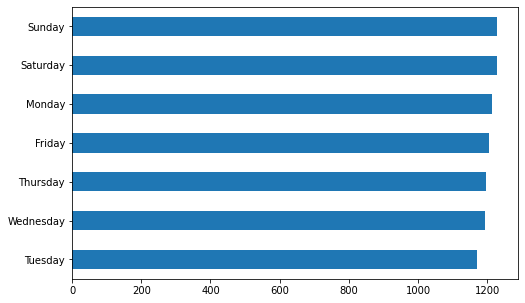


Precipitation


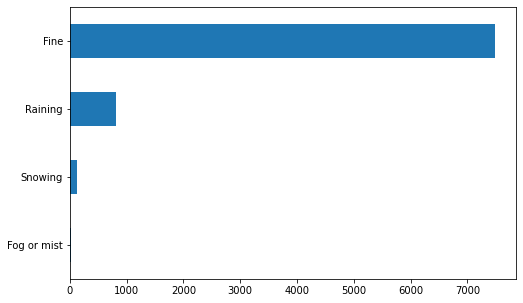


High_Winds


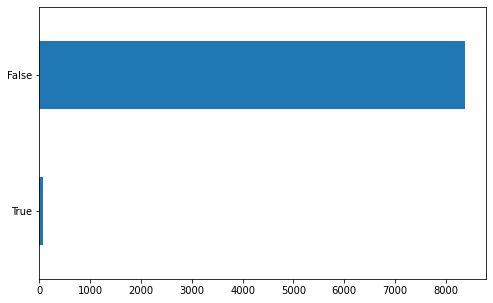


Road_Surface_Conditions


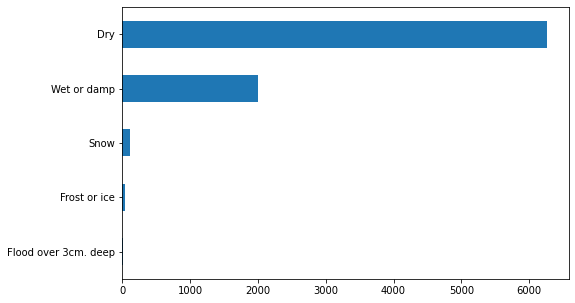


Light_Conditions


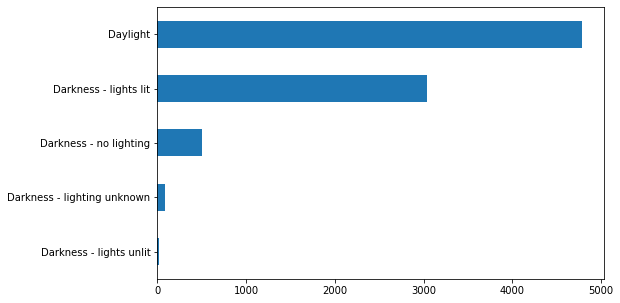


Urban_or_Rural_Area


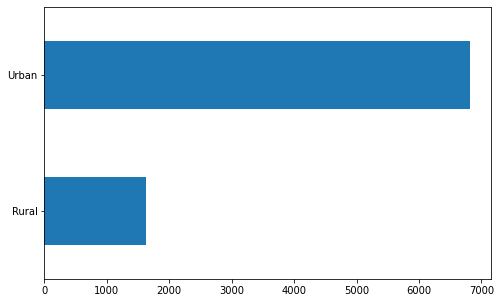

In [6]:
for i in df.columns[2:]:
    print(i)
    plt.figure(figsize=(8, 5))
    ax = df[i].value_counts().plot(kind="barh")
    ax.invert_yaxis()
    plt.show()
    print()

df.pivot_table(index=(['Urban_or_Rural_Area','Day_of_Week'])
               , values='Count'
               , aggfunc=("count","sum")
              ).reset_index().sort_values('count', ascending=False)

# Forecasting time series

Select 2 columns for forecasting

In [7]:
df2 = df[['datetime', 'Count']]

In [8]:
df2.DatetimeIndex = df2.datetime
del df2['datetime']

In [9]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(df2, test_size=0.1, random_state=7, shuffle=False)
print(f"{train_set.shape[0]} train and {test_set.shape[0]} test instances")

7594 train and 844 test instances


## Exploratory Data Analysis

Let's plot the data.

<AxesSubplot:>

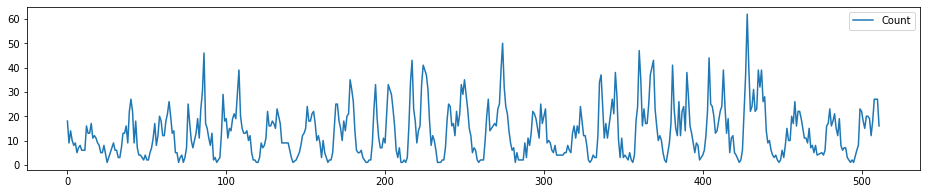

In [10]:
train_set[:500].plot(figsize=(16,3))

## Data cleaning and transformation

Before we can start buinding a model, we need to ensure the data is **stationary**. We will use the Augmented Dickey-Fuller (ADF) test and the KPSS (Kwiatkowski-Phillips-Schmidt-Shin) tests to test the series for stationarity.

In [11]:
from statsmodels.tsa.stattools import adfuller, kpss

adf_pval = adfuller(train_set['Count'], maxlag=10, regression='nc')[1]
print("ADF, p-value:", adf_pval)

ADF, p-value: 5.622377150770526e-24


In [12]:
kpss_stat, kpss_pval, lags, crit_vals = kpss(train_set['Count'])
print("KPSS, p-value:", round(kpss_pval,2))

KPSS, p-value: 0.01


/Users/Edite/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1708: InterpolationWarning: p-value is smaller than the indicated p-value
  warn("p-value is smaller than the indicated p-value", InterpolationWarning)


**InterpolationWarning**

InterpolationWarning is issued when the test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is {direction} than the p-value returned. Not present for ADF.

    if p_value == pvals[-1]:
        warnings.warn(
            warn_msg.format(direction="smaller"), InterpolationWarning
        )
    elif p_value == pvals[0]:
        warnings.warn(
            warn_msg.format(direction="greater"), InterpolationWarning
        )


[Source code](https://www.statsmodels.org/dev/_modules/statsmodels/tsa/stattools.html)




In [13]:
def Trending(adf_pval, kpss_stat):
    if adf_pval>0.05 and kpss_pval < 0.05:
        return "non-Stationary"
    elif adf_pval<0.05 and kpss_pval > 0.05:
        return "Stationary"
    elif adf_pval>0.05 and kpss_pval > 0.05:
        return "3: ADF : non-Stationary, KPSS : Stationary"
    elif adf_pval<0.05 and kpss_pval < 0.05:
        return "ADF : Stationary, KPSS : non-Stationary"

In [14]:
Trending(adf_pval,kpss_pval )

'ADF : Stationary, KPSS : non-Stationary'

The series is not stationary in the levels (i.e., in the original form), according to the KPSS test, but it is stationary according to the ADF test. So it would be safer to assume that the series is not stationary. Let us difference it.

In [15]:
train_diff = train_set['Count'].diff().dropna()

adf_pval = adfuller(train_diff, maxlag=10, regression="nc")[1]
kpss_stat, kpss_pval, lags, crit_vals = kpss(train_diff)
Trending(adf_pval, kpss_pval)

/Users/Edite/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1710: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)


'Stationary'

The series has become stationary after the first differencing, so we'll use a differenced training set for building a model and we'll also difference the test data in order to be able to evaluate the model.

In [16]:
test_diff = test_set['Count'].diff().dropna()

## Build models

### Baseline

The persistence baseline is generating the previous hours accidents as the prediction for next hour. Baseline is 10.6 accidents per hour. If baseline would be derived as average accidents in the test data set, base line would be 14.5.

In [17]:
baseline_predictions = test_diff.shift()[1:]

mse = mean_squared_error(test_diff[1:], baseline_predictions)

baseline_rmse = np.sqrt(mse)
baseline_rmse

10.566832886189484

In [18]:
test_set['Count'].mean()

14.531990521327014

### Extra transformation steps

We need to do some transformation steps required to be able to input the data into the scikit-learn's implementation of the ML algorithms.

In [19]:
def create_ar_vars(ts, lags=2):
    """Create autoregressive X variables
    """
    dataX, dataY = [], []
    for i in range(len(ts)-lags):
        dataX.append(ts[i:i + lags, 0])
        dataY.append(ts[i + lags, 0])
    return np.array(dataX), np.array(dataY)

We first create separate arrays for the predictors and the target, for both the training and test data. We'll use 3 lags to create autoregressive variables.

In [20]:
Xtrain, ytrain = create_ar_vars(train_diff.values.reshape(-1, 1), lags=3)
Xtest, ytest = create_ar_vars(test_diff.values.reshape(-1, 1), lags=3)

Both predictor arrays need to be scaled (but the target variable should not be transformed).

In [21]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
Xtrain = scaler.fit_transform(Xtrain)
Xtest = scaler.transform(Xtest)

Then we can use a grid search to find the most optimal hyperparameters settings.

### Decision Tree regression

We'll fine-tune `min_samples_split` (the minimum number of instances required to be at a node before it gets split) and `max_depth` (the maximum depth of each tree).

In [22]:
dtree = DecisionTreeRegressor(random_state=7)
param_grid = [
    {'max_depth': [2, 5, 4, 6, 8],
    'min_samples_split': [2, 4, 6, 8, 3, 10, 9, 11]}
]

tscv = TimeSeriesSplit(n_splits=5)
dtree_grid_search = GridSearchCV(estimator=dtree, cv=tscv,
                        param_grid=param_grid,
                        scoring='neg_mean_squared_error', 
                        return_train_score=True)

start = time.time()
dtree_grid_search.fit(Xtrain, ytrain)

GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=5),
             error_score=nan,
             estimator=DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse',
                                             max_depth=None, max_features=None,
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             presort='deprecated',
                                             random_state=7, splitter='best'),
             iid='deprecated', n_jobs=None,
             param_grid=[{'max_depth': [2, 5, 4, 6, 8],
                          'min_samples_split': [2, 4, 6, 8, 3, 10, 9, 11]}],
          

In [23]:
val_scores = dtree_grid_search.cv_results_["mean_test_score"]
train_scores = dtree_grid_search.cv_results_["mean_train_score"]
params = [str(x) for x in dtree_grid_search.cv_results_["params"]]

for val_score, train_score, param in sorted(zip(val_scores, train_scores, params), reverse=True):
    print(f"{np.sqrt(-val_score):.3f}, {np.sqrt(-train_score):.3f}, {np.sqrt(-val_score)/np.sqrt(-train_score):.3f}", param)

7.062, 6.600, 1.070 {'max_depth': 5, 'min_samples_split': 10}
7.066, 6.609, 1.069 {'max_depth': 5, 'min_samples_split': 11}
7.072, 6.491, 1.089 {'max_depth': 6, 'min_samples_split': 10}
7.077, 6.503, 1.088 {'max_depth': 6, 'min_samples_split': 11}
7.108, 6.591, 1.078 {'max_depth': 5, 'min_samples_split': 8}
7.110, 6.592, 1.079 {'max_depth': 5, 'min_samples_split': 9}
7.116, 6.730, 1.057 {'max_depth': 4, 'min_samples_split': 4}
7.116, 6.730, 1.057 {'max_depth': 4, 'min_samples_split': 3}
7.116, 6.730, 1.057 {'max_depth': 4, 'min_samples_split': 2}
7.116, 6.730, 1.057 {'max_depth': 4, 'min_samples_split': 6}
7.120, 6.732, 1.058 {'max_depth': 4, 'min_samples_split': 9}
7.120, 6.732, 1.058 {'max_depth': 4, 'min_samples_split': 8}
7.120, 6.732, 1.058 {'max_depth': 4, 'min_samples_split': 11}
7.120, 6.732, 1.058 {'max_depth': 4, 'min_samples_split': 10}
7.124, 6.583, 1.082 {'max_depth': 5, 'min_samples_split': 6}
7.124, 6.579, 1.083 {'max_depth': 5, 'min_samples_split': 2}
7.125, 6.579, 1.08

### Random Forest regression

We'll fine-tune `n_estimators` (the number of decision trees used in the random forest) as well as `min_samples_split` and `max_depth` (hyperparameters of specific trees).

In [24]:
rf = RandomForestRegressor(random_state=7)
param_grid = [
    {'n_estimators': [2, 3, 5, 10, 15, 20, 30, 40, 50], 
     'max_depth': [2, 4, 6, 8],
     'min_samples_split': [ 8, 10, 9, 11]
    },
]

tscv = TimeSeriesSplit(n_splits=5)
rf_grid_search = GridSearchCV(estimator=rf, cv=tscv,
                        param_grid=param_grid,
                        scoring='neg_mean_squared_error', 
                        return_train_score=True)

start = time.time()
rf_grid_search.fit(Xtrain, ytrain)

GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=5),
             error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=None,
                                             oob_score=False, random_state=7,
                                             verbose=

Let's print the accuracy scores for every model evaluated during the grid search.

In [25]:
val_scores = rf_grid_search.cv_results_["mean_test_score"]
train_scores = rf_grid_search.cv_results_["mean_train_score"]
params = [str(x) for x in rf_grid_search.cv_results_["params"]]
   
for val_score, train_score, param in sorted(zip(val_scores, train_scores, params), reverse=True):
    print(f"{np.sqrt(-val_score):.3f}, {np.sqrt(-train_score):.3f}, {np.sqrt(-val_score)/np.sqrt(-train_score):.3f}", param)

6.882, 6.144, 1.120 {'max_depth': 8, 'min_samples_split': 11, 'n_estimators': 20}
6.885, 6.129, 1.123 {'max_depth': 8, 'min_samples_split': 10, 'n_estimators': 20}
6.886, 6.115, 1.126 {'max_depth': 8, 'min_samples_split': 9, 'n_estimators': 20}
6.887, 6.127, 1.124 {'max_depth': 8, 'min_samples_split': 11, 'n_estimators': 40}
6.888, 6.161, 1.118 {'max_depth': 8, 'min_samples_split': 11, 'n_estimators': 15}
6.889, 6.112, 1.127 {'max_depth': 8, 'min_samples_split': 10, 'n_estimators': 40}
6.889, 6.101, 1.129 {'max_depth': 8, 'min_samples_split': 8, 'n_estimators': 20}
6.890, 6.144, 1.121 {'max_depth': 8, 'min_samples_split': 10, 'n_estimators': 15}
6.890, 6.131, 1.124 {'max_depth': 8, 'min_samples_split': 9, 'n_estimators': 15}
6.891, 6.116, 1.127 {'max_depth': 8, 'min_samples_split': 11, 'n_estimators': 50}
6.891, 6.097, 1.130 {'max_depth': 8, 'min_samples_split': 9, 'n_estimators': 40}
6.891, 6.132, 1.124 {'max_depth': 8, 'min_samples_split': 11, 'n_estimators': 30}
6.892, 6.103, 1.129 

The best models with both DT and RF methods do not seem to overfit too much, and their cross-validation RMSEs are quite above the baseline.

## Evaluate the best DT and RF models on the test data

#### Decision tree

In [26]:
best_model = dtree_grid_search.best_estimator_

yhat = best_model.predict(Xtest)

dtree_mse = mean_squared_error(ytest, yhat)
dtree_rmse = np.sqrt(dtree_mse)
dtree_rmse

7.381144660907249

In [27]:
best_model = rf_grid_search.best_estimator_

yhat = best_model.predict(Xtest)

rf_mse = mean_squared_error(ytest, yhat)
rf_rmse = np.sqrt(rf_mse)
rf_rmse

7.201542933554125

In [28]:
100*(baseline_rmse - dtree_rmse)/baseline_rmse

30.147994764314188

By how much did the RF model improve on the persistence baseline, percent-wise?

In [29]:
100*(baseline_rmse - rf_rmse)/baseline_rmse

31.847668917274987

## Conclusion

The Decision Tree regression model reduced the RMSE rate by 30%, while the RandomForest regression method by 31%, compared to the persistence baseline.

# Feature generation for regression

Can the error be reduced by generation additional features and using regression instead of time series forecasting. 

##  Dr Strange 

### Function TimeSplit
It takes datetime column and derives following new features:
* Hour (0-23)
* dayofweek (1-7)
* quarter (1-4)
* month(1-12)
* dayofyear (1-365)
* dayofmonth(1-31)
* weekofyear(1-52)

Extracting year does not serve any purpose as data set contains only 2018.

In [30]:
def TimeSplit(df, label=None):
    """
    Creates time series features from datetime index
    """
    df['datetime'] = pd.to_datetime(df['datetime'], format="%d/%m/%Y %H:%M" , errors='coerce')
    df['Hour'] = df['datetime'].dt.hour
    #df['Dayofweek'] = df['datetime'].dt.dayofweek+1
    df['Quarter'] = df['datetime'].dt.quarter
    df['Month'] = df['datetime'].dt.month
    #df['year'] = df['Date'].dt.year
    #df['dayofyear'] = df['datetime'].dt.dayofyear
    df['Dayofmonth'] = df['datetime'].dt.day
    df['Weekofyear'] = df['datetime'].dt.weekofyear
    
    
    X = df[['Hour','Quarter','Month','Dayofmonth','Weekofyear'
            #,'year','dayofyear','Dayofweek'
            ]]
    return X

In [31]:
TimeSplit(df)

,Hour,Quarter,Month,Dayofmonth,Weekofyear
0,0,1,1,1,1
1,1,1,1,1,1
2,2,1,1,1,1
3,3,1,1,1,1
4,4,1,1,1,1
...,...,...,...,...,...
8535,19,4,12,31,1
8536,20,4,12,31,1
8537,21,4,12,31,1
8538,22,4,12,31,1


In [32]:
df.sample(10)

,datetime,Count,Day_of_Week,Precipitation,High_Winds,Road_Surface_Conditions,Light_Conditions,Urban_or_Rural_Area,Hour,Quarter,Month,Dayofmonth,Weekofyear
7698,2018-11-26 02:00:00,1,Monday,Fine,False,Dry,Darkness - no lighting,Urban,2,4,11,26,48
8215,2018-12-18 04:00:00,3,Tuesday,Raining,False,Wet or damp,Darkness - no lighting,Rural,4,4,12,18,51
3804,2018-06-13 10:00:00,14,Wednesday,Fine,False,Dry,Daylight,Rural,10,2,6,13,24
2171,2018-04-04 14:00:00,13,Wednesday,Fine,False,Wet or damp,Daylight,Rural,14,2,4,4,14
8492,2018-12-29 23:00:00,14,Saturday,Fine,False,Dry,Darkness - lights lit,Urban,23,4,12,29,52
7960,2018-12-07 07:00:00,32,Friday,Raining,False,Wet or damp,Darkness - lights lit,Urban,7,4,12,7,49
1349,2018-02-28 05:00:00,7,Wednesday,Snowing,False,Snow,Darkness - lights lit,Urban,5,1,2,28,9
7278,2018-11-08 05:00:00,7,Thursday,Fine,False,Wet or damp,Darkness - no lighting,Rural,5,4,11,8,45
5345,2018-08-17 22:00:00,14,Friday,Fine,False,Dry,Darkness - lights lit,Urban,22,3,8,17,33
4231,2018-07-01 12:00:00,24,Sunday,Fine,False,Dry,Daylight,Rural,12,3,7,1,26


### Function TimeOfDay 

It takes hour derived with the previous function and splits in 5 categories:
* morning rush (5-10)
* office hours (10-15)
* afternoon rush (15-19)
* evening (19-23)
* night (23-5)

In [33]:
def TimeOfDay(hour):
    if hour >= 5 and hour < 10:
        return "Morning rush (5-10)"
    elif hour >= 10 and hour < 15:
        return "Office hours (10-15)"
    elif hour >= 15 and hour < 19:
        return "Afternoon rush (15-19)"
    elif hour >= 19 and hour < 23:
        return "Evening (19-23)"
    else:
        return "Night (23-5)"

In [34]:
df['Time_of_Day'] = df['Hour'].apply(TimeOfDay)

Package holidays are imported and respective holidays for England in 2018 is appended to dataframe bank_holidays. 
United_Kingdom contains holidays for Scotland, Wales and Ireland, which are not Bank holidays across all United Kingdom. 

In [35]:
import holidays 
uk_holidays = holidays.UnitedKingdom() 
bank_holidays = []

for ptr in holidays.England(years = 2018).items(): 
    bank_holidays.append(str(ptr[0]))

### Function Is_it_weekend 
Returning 1 if it is Sunday, Saturday or Bank Holiday in England. 

In [36]:
def is_it_weekend(x):
    m = x.normalize()
    if m.dayofweek+1 == 6:
        return 1
    elif m.dayofweek+1 == 7:
        return 1
    elif str(m.date()) in bank_holidays:
        return 1
    else:
        return 0

In [37]:
df['Is_weekend'] = df.datetime.apply(is_it_weekend)

In [38]:
#Function to change True/False to 1/0

def Liking(x):
    if str.lower(str(x)) == "true":
        return 1
    else:
        return 0 

In [39]:
df.High_Winds = df.High_Winds.apply(Liking)

In [40]:
df.sample(5)

,datetime,Count,Day_of_Week,Precipitation,High_Winds,Road_Surface_Conditions,Light_Conditions,Urban_or_Rural_Area,Hour,Quarter,Month,Dayofmonth,Weekofyear,Time_of_Day,Is_weekend
122,2018-01-06 07:00:00,9,Saturday,Fine,0,Frost or ice,Daylight,Urban,7,1,1,6,1,Morning rush (5-10),1
4320,2018-07-05 07:00:00,24,Thursday,Fine,0,Dry,Daylight,Urban,7,3,7,5,27,Morning rush (5-10),0
7034,2018-10-28 20:00:00,7,Sunday,Fine,0,Dry,Darkness - lights lit,Urban,20,4,10,28,43,Evening (19-23),1
2189,2018-04-05 08:00:00,19,Thursday,Fine,0,Dry,Daylight,Urban,8,2,4,5,14,Morning rush (5-10),0
3572,2018-06-03 08:00:00,9,Sunday,Fine,0,Dry,Daylight,Rural,8,2,6,3,22,Morning rush (5-10),1


Create a new feature "Urban" based on Urban_or_Rural_Area. Returns 1 if Urban and 0 if Rural. 
Deletes column Urban_or_Rural_Area.
This is done so column name does not become extremely long and confusing. One hot encoding would create column named "Urban_or_Rural_Area_Urban". 
In case of using SHAP to explain machine learning model, approximately one third of variable name would be displayed, which in result would not aid in explaining black box of machine learning. 

In [41]:
df['Urban']= np.where(df['Urban_or_Rural_Area'] == "Urban" , 1, 0)
del df['Urban_or_Rural_Area']

In [42]:
df.describe()

,Count,High_Winds,Hour,Quarter,Month,Dayofmonth,Weekofyear,Is_weekend,Urban
count,8438.000000,8438.000000,8438.000000,8438.000000,8438.000000,8438.000000,8438.000000,8438.000000,8438.000000
mean,14.505689,0.008177,11.795094,2.518369,6.547997,15.738327,26.536857,0.313344,0.807300
std,10.455079,0.090063,6.833816,1.113807,3.437139,8.801340,15.000976,0.463881,0.394443
min,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000
25%,6.000000,0.000000,6.000000,2.000000,4.000000,8.000000,14.000000,0.000000,1.000000
50%,13.000000,0.000000,12.000000,3.000000,7.000000,16.000000,27.000000,0.000000,1.000000
75%,21.000000,0.000000,18.000000,4.000000,10.000000,23.000000,40.000000,1.000000,1.000000
max,62.000000,1.000000,23.000000,4.000000,12.000000,31.000000,52.000000,1.000000,1.000000


## Create  dummies 

In [43]:
df.columns

Index(['datetime', 'Count', 'Day_of_Week', 'Precipitation', 'High_Winds',
       'Road_Surface_Conditions', 'Light_Conditions', 'Hour', 'Quarter',
       'Month', 'Dayofmonth', 'Weekofyear', 'Time_of_Day', 'Is_weekend',
       'Urban'],
      dtype='object')

In [44]:
df2 = pd.get_dummies(df, drop_first=True)

In [45]:
df2.sample(5).T

,413,5199,7854,980,5131
datetime,2018-01-18 17:00:00,2018-08-11 17:00:00,2018-12-02 16:00:00,2018-02-12 05:00:00,2018-08-08 21:00:00
Count,39,19,18,2,7
High_Winds,0,0,0,0,0
Hour,17,17,16,5,21
Quarter,1,3,4,1,3
Month,1,8,12,2,8
Dayofmonth,18,11,2,12,8
Weekofyear,3,32,48,7,32
Is_weekend,0,1,1,0,0
Urban,1,1,1,0,1


In [46]:
corr_matrix = df2.corr()
corr_matrix['Count'].sort_values(ascending=False)

Count                                           1.000000
Light_Conditions_Daylight                       0.455375
Hour                                            0.365645
Urban                                           0.301672
Time_of_Day_Office hours (10-15)                0.191140
Day_of_Week_Thursday                            0.041966
Weekofyear                                      0.041304
Quarter                                         0.035880
Month                                           0.035640
Day_of_Week_Wednesday                           0.034674
Day_of_Week_Tuesday                             0.030162
Day_of_Week_Monday                              0.002505
Dayofmonth                                     -0.003169
Road_Surface_Conditions_Frost or ice           -0.019573
Road_Surface_Conditions_Flood over 3cm. deep   -0.028196
Precipitation_Snowing                          -0.039278
Road_Surface_Conditions_Snow                   -0.046214
Day_of_Week_Saturday           

# Linear regression

In [47]:
train_set, test_set = train_test_split(df2, test_size=0.1, random_state=7, shuffle=False)
print(f"{train_set.shape[0]} train and {test_set.shape[0]} test instances")

7594 train and 844 test instances


In [48]:
Xtrain = train_set[['High_Winds', 'Hour', 'Quarter', 'Month',
       'Dayofmonth', 'Weekofyear', 'Is_weekend', 'Urban', 'Day_of_Week_Monday',
       'Day_of_Week_Saturday', 'Day_of_Week_Sunday', 'Day_of_Week_Thursday',
       'Day_of_Week_Tuesday', 'Day_of_Week_Wednesday',
       'Precipitation_Fog or mist', 'Precipitation_Raining',
       'Precipitation_Snowing', 'Road_Surface_Conditions_Flood over 3cm. deep',
       'Road_Surface_Conditions_Frost or ice', 'Road_Surface_Conditions_Snow',
       'Road_Surface_Conditions_Wet or damp',
       'Light_Conditions_Darkness - lights lit',
       'Light_Conditions_Darkness - lights unlit',
       'Light_Conditions_Darkness - no lighting', 'Light_Conditions_Daylight',
       'Time_of_Day_Evening (19-23)', 'Time_of_Day_Morning rush (5-10)',
       'Time_of_Day_Night (23-5)', 'Time_of_Day_Office hours (10-15)']]

ytrain = train_set['Count']

In [49]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()

lin_reg.fit(Xtrain, ytrain)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [50]:
# make predictions
yhat = lin_reg.predict(Xtrain)

lin_mse = mean_squared_error(ytrain, yhat)

# take square root
lin_rmse = np.sqrt(lin_mse)

lin_rmse

6.877592809712238

In [51]:
from sklearn.model_selection import cross_val_score

lin_reg = LinearRegression()
scores = cross_val_score(lin_reg, Xtrain, ytrain,
                         scoring="neg_mean_squared_error", cv=10)
rmse_scores = np.sqrt(-scores)

def display_scores(scores):
    print("Scores:", scores, scores < 7.2)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std()) 
    
display_scores(rmse_scores)

Scores: [7.52156064 6.84101071 6.70611634 7.26938994 6.93635611 7.58267261
 5.67804379 6.53360723 7.27307227 7.38019337] [False  True  True False  True False  True  True False False]
Mean: 6.972202301406665
Standard deviation: 0.5455527792915901


It turns out that linear regression has a slightly lower average error rate than Decision Trees, and at the same time exhibits lower variance.

In [52]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor()
tree_reg.fit(Xtrain, ytrain)
yhat = tree_reg.predict(Xtrain)
tree_mse = mean_squared_error(ytrain, yhat)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

0.0

# Decision Tree regression

We'll fine-tune `min_samples_split` (the minimum number of instances required to be at a node before it gets split) and `max_depth` (the maximum depth of each tree).

In [53]:
dtree = DecisionTreeRegressor(random_state=7)
param_grid = [
    {'max_depth': [2, 5, 4, 6, 8],
    'min_samples_split': [2, 4, 6, 8, 3, 10, 9, 11]}
]

tscv = TimeSeriesSplit(n_splits=5)
dtree_grid_search = GridSearchCV(estimator=dtree, cv=tscv,
                        param_grid=param_grid,
                        scoring='neg_mean_squared_error', 
                        return_train_score=True)

start = time.time()
dtree_grid_search.fit(Xtrain, ytrain)

GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=5),
             error_score=nan,
             estimator=DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse',
                                             max_depth=None, max_features=None,
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             presort='deprecated',
                                             random_state=7, splitter='best'),
             iid='deprecated', n_jobs=None,
             param_grid=[{'max_depth': [2, 5, 4, 6, 8],
                          'min_samples_split': [2, 4, 6, 8, 3, 10, 9, 11]}],
          

In [54]:
val_scores = dtree_grid_search.cv_results_["mean_test_score"]
train_scores = dtree_grid_search.cv_results_["mean_train_score"]
params = [str(x) for x in dtree_grid_search.cv_results_["params"]]

for val_score, train_score, param in sorted(zip(val_scores, train_scores, params), reverse=True):
    print(f"{np.sqrt(-val_score):.3f}, {np.sqrt(-train_score):.3f}, {np.sqrt(-val_score)/np.sqrt(-train_score):.3f}", param)

5.706, 4.630, 1.232 {'max_depth': 8, 'min_samples_split': 10}
5.707, 4.637, 1.231 {'max_depth': 8, 'min_samples_split': 11}
5.713, 4.622, 1.236 {'max_depth': 8, 'min_samples_split': 8}
5.713, 4.628, 1.235 {'max_depth': 8, 'min_samples_split': 9}
5.720, 5.188, 1.103 {'max_depth': 6, 'min_samples_split': 11}
5.720, 5.188, 1.103 {'max_depth': 6, 'min_samples_split': 10}
5.729, 5.183, 1.105 {'max_depth': 6, 'min_samples_split': 6}
5.729, 5.181, 1.106 {'max_depth': 6, 'min_samples_split': 3}
5.730, 5.186, 1.105 {'max_depth': 6, 'min_samples_split': 9}
5.731, 5.185, 1.105 {'max_depth': 6, 'min_samples_split': 8}
5.732, 4.609, 1.244 {'max_depth': 8, 'min_samples_split': 6}
5.734, 5.181, 1.107 {'max_depth': 6, 'min_samples_split': 2}
5.740, 5.181, 1.108 {'max_depth': 6, 'min_samples_split': 4}
5.750, 4.598, 1.251 {'max_depth': 8, 'min_samples_split': 3}
5.754, 4.602, 1.251 {'max_depth': 8, 'min_samples_split': 4}
5.756, 4.596, 1.252 {'max_depth': 8, 'min_samples_split': 2}
5.890, 5.481, 1.075 

# Random Forest regression

In [55]:
rf = RandomForestRegressor(random_state=7)
param_grid = [
    {'n_estimators': [2, 3, 5, 10, 15, 20, 30, 40, 50], 
     'max_depth': [2, 4, 6, 8],
     'min_samples_split': [ 8, 10, 9, 11]
    },
]

tscv = TimeSeriesSplit(n_splits=5)
rf_grid_search = GridSearchCV(estimator=rf, cv=tscv,
                        param_grid=param_grid,
                        scoring='neg_mean_squared_error', 
                        return_train_score=True)

start = time.time()
rf_grid_search.fit(Xtrain, ytrain)

GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=5),
             error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=None,
                                             oob_score=False, random_state=7,
                                             verbose=

Let's print the accuracy scores for every model evaluated during the grid search.

In [56]:
val_scores = rf_grid_search.cv_results_["mean_test_score"]
train_scores = rf_grid_search.cv_results_["mean_train_score"]
params = [str(x) for x in rf_grid_search.cv_results_["params"]]
   
for val_score, train_score, param in sorted(zip(val_scores, train_scores, params), reverse=True):
    print(f"{np.sqrt(-val_score):.3f}, {np.sqrt(-train_score):.3f}, {np.sqrt(-val_score)/np.sqrt(-train_score):.3f}", param)

5.381, 4.425, 1.216 {'max_depth': 8, 'min_samples_split': 11, 'n_estimators': 50}
5.387, 4.408, 1.222 {'max_depth': 8, 'min_samples_split': 9, 'n_estimators': 50}
5.387, 4.417, 1.220 {'max_depth': 8, 'min_samples_split': 10, 'n_estimators': 50}
5.387, 4.436, 1.214 {'max_depth': 8, 'min_samples_split': 11, 'n_estimators': 40}
5.391, 4.400, 1.225 {'max_depth': 8, 'min_samples_split': 8, 'n_estimators': 50}
5.393, 4.428, 1.218 {'max_depth': 8, 'min_samples_split': 10, 'n_estimators': 40}
5.395, 4.419, 1.221 {'max_depth': 8, 'min_samples_split': 9, 'n_estimators': 40}
5.400, 4.410, 1.224 {'max_depth': 8, 'min_samples_split': 8, 'n_estimators': 40}
5.426, 4.434, 1.224 {'max_depth': 8, 'min_samples_split': 11, 'n_estimators': 30}
5.435, 4.426, 1.228 {'max_depth': 8, 'min_samples_split': 10, 'n_estimators': 30}
5.436, 4.417, 1.231 {'max_depth': 8, 'min_samples_split': 9, 'n_estimators': 30}
5.442, 4.408, 1.235 {'max_depth': 8, 'min_samples_split': 8, 'n_estimators': 30}
5.450, 4.455, 1.223 {'

# Random Forest

Finally, let's evaluate a RandomForest regression algorithm. Random Forests work by training many Decision Trees on random subsets of the features, then averaging out their predictions.

We specify that we want the algorithm to use 10 decision trees. We do that by passing `n_estimators=10` when we initialize the `RandomForestRegressor` class 

The algorithm produced a much lower RMSE score (47,820) than either Decision Trees or linear regression methods. It seems to be a particularly suitable algorithm to be explored further.

In the previous experiment, we used 10 decision trees in the Random Forest algorithm. This setting is called a hyperparameter of the algorithm, and needs to be set before a model is trained.

We might experiment with several different settings of the hyperparameter to find its optimal settings. However, many algorithms have quite a few of such hyperparameters. Scikit-learn has a utility to automatically search for the best combination of hyperparameter values, implemented in the `GridSearchCV` class. 

### Exhaustive grid search

`GridSearchCV` takes a set of hyperparameters and the search range for each hyperparameter, constructs a search grid with all possible hyperparameter combinations, and evaluates each combination using cross-validation. The output is the model with the best cross-validation accuracy.

Let's take a look at an example. We will train a RandomForest regressor, searching for the best model in the grid created from two hyperparameters: `n_estimators` (the number of decision trees, trying values 3, 10 and 30) and `max_depth` (the maximum depth of each tree, trying values 4, 6, 8 and None - None being the maximum possible depth, the default value). So, the grid search will involve creating and evaluating 12 models using cross-validation.

In [57]:
from sklearn.model_selection import GridSearchCV

# specify the hyperparameters and their values
param_grid = [
    {'n_estimators': [3, 10, 30], 'max_depth': [4, 6, 8, None]},
]

forest_reg = RandomForestRegressor(random_state=7)

# we'll use 10-fold cross-validation
grid_search = GridSearchCV(forest_reg, param_grid, cv=10,
                           scoring='neg_mean_squared_error', 
                           return_train_score=True)

grid_search.fit(Xtrain, ytrain)

GridSearchCV(cv=10, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=None,
                                             oob_score=False, random_state=7,
                                             verbose=0, warm_start=False),
             iid='deprecated', n_jobs

Once grid search is complete we can obtain the best model and its accuracy score: they are attributes on the `GridSearchCV` class:

In [58]:
grid_search.best_estimator_

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=8, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=30, n_jobs=None, oob_score=False,
                      random_state=7, verbose=0, warm_start=False)

The best model proved to be one with `n_estimator=30` and `max_depth=None`.

Let's look up its RMSE.

In [59]:
np.sqrt(-grid_search.best_score_)

5.195180632887147

Thus by tuning hyperparameters, we were able to further reduce the error rate (from 47820 to 46209). 

You could have noticed that the largest value of `n_estimators` we tried (30) produced the best result. This suggests we should try even greater values - we could improve the error rate further.

We can also access RMSE scores of each model trained during grid search. They are stored in the `cv_results_` attribute:

The best-performing model showed a much lower RMSE on the training set (17985) than on the test set (46209). This indicates the model overfitted the training data. The overfitting could be reduced and the model further improved by introducing constraints on the learned trees (for example, enforcing a maximum depth of the learned trees).

## 5.5 Analyze the most promising models

We can examine what variables were the most important for the regression problem in the best-performing model. They are also stored as an attribute on the model object:

In [60]:
# put them into a separate variable for convenience
feature_importances = grid_search.best_estimator_.feature_importances_

# the order of the features in `feature_importances` is the same as in the Xtrain dataframe,
# so we can "zip" the two and print in the descending order:

for k, v in sorted(zip(feature_importances, Xtrain.columns), reverse=True):
    print(f"{v}: {k}")

Hour: 0.7945086630196462
Is_weekend: 0.06856406958688961
Weekofyear: 0.0374159785940059
Time_of_Day_Office hours (10-15): 0.03499782708398361
Time_of_Day_Morning rush (5-10): 0.016933478275217306
Time_of_Day_Evening (19-23): 0.015907327038465528
Dayofmonth: 0.007812514036179866
Day_of_Week_Saturday: 0.004598600512811241
Month: 0.004178430510168855
Urban: 0.003217989879140609
Light_Conditions_Darkness - lights lit: 0.002142965401511673
Day_of_Week_Monday: 0.0014514861751766949
Day_of_Week_Sunday: 0.001175193705596254
Precipitation_Raining: 0.0010521221833500888
Day_of_Week_Tuesday: 0.0010111480005218399
Light_Conditions_Daylight: 0.0008940513376108555
Road_Surface_Conditions_Wet or damp: 0.0008133433955985458
Quarter: 0.0006868178000413155
Day_of_Week_Wednesday: 0.0005127097681662846
Time_of_Day_Night (23-5): 0.0004232027498240846
Precipitation_Snowing: 0.00040147623303655533
Road_Surface_Conditions_Snow: 0.00038995099121696616
Road_Surface_Conditions_Frost or ice: 0.0003290620024137193

We can notice that median income is by far the most useful variable for predicting the price of housing. Other useful features are the position of the district relative to the ocean, the average number of persons per household in a district.

There are some features that are much less useful: "NEAR OCEAN", "NEAR BAY" and "ISLAND". We may consider removing them both from the training and test set.

It often helps to also visualize the predictions made by the model. Let's refit the best model on the first 90% of the training set and generate predictions on the last 10%. There are 15736 training instances, so we will use 14162 for training and the rest for testing.

# Random Forest Regressor

In [61]:
from sklearn.model_selection import GridSearchCV

from sklearn.ensemble import RandomForestRegressor

# specify the hyperparameters and their values

param_grid = [
    {'n_estimators': [2, 3, 5, 10], 
     'max_depth': [2, 4, 6, 8, None],
     'min_samples_split': [2, 4, 6, 8]
    },
]
forest_reg = RandomForestRegressor(random_state=7)

# we'll use 10-fold cross-validation
rf_grid_search = GridSearchCV(forest_reg, param_grid, cv=10, 
                              scoring='neg_mean_squared_error',
                              return_train_score=True)

rf_grid_search.fit(Xtrain, ytrain)

GridSearchCV(cv=10, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=None,
                                             oob_score=False, random_state=7,
                                             verbose=0, warm_start=False),
             iid='deprecated', n_jobs

In [62]:
# the best model

rf_grid_search.best_estimator_

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=8, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=8, min_weight_fraction_leaf=0.0,
                      n_estimators=10, n_jobs=None, oob_score=False,
                      random_state=7, verbose=0, warm_start=False)

In [63]:
# the best model's RMSE

np.sqrt(-rf_grid_search.best_score_)

5.222572850648849

In [64]:
# training and validation RMSE

val_scores = rf_grid_search.cv_results_["mean_test_score"]
train_scores = rf_grid_search.cv_results_["mean_train_score"]
params = rf_grid_search.cv_results_["params"]

for val_score, train_score, param in zip(val_scores, train_scores, params):
    print(np.sqrt(-val_score), np.sqrt(-train_score), param)

7.2163399808592565 7.180762734340544 {'max_depth': 2, 'min_samples_split': 2, 'n_estimators': 2}
7.22417343524722 7.180702169424574 {'max_depth': 2, 'min_samples_split': 2, 'n_estimators': 3}
7.219337425335175 7.180253846711606 {'max_depth': 2, 'min_samples_split': 2, 'n_estimators': 5}
7.21394464556634 7.180023229656101 {'max_depth': 2, 'min_samples_split': 2, 'n_estimators': 10}
7.2163399808592565 7.180762734340544 {'max_depth': 2, 'min_samples_split': 4, 'n_estimators': 2}
7.22417343524722 7.180702169424574 {'max_depth': 2, 'min_samples_split': 4, 'n_estimators': 3}
7.219337425335175 7.180253846711606 {'max_depth': 2, 'min_samples_split': 4, 'n_estimators': 5}
7.21394464556634 7.180023229656101 {'max_depth': 2, 'min_samples_split': 4, 'n_estimators': 10}
7.2163399808592565 7.180762734340544 {'max_depth': 2, 'min_samples_split': 6, 'n_estimators': 2}
7.22417343524722 7.180702169424574 {'max_depth': 2, 'min_samples_split': 6, 'n_estimators': 3}
7.219337425335175 7.180253846711606 {'ma

**Comments**: The best model is achieved with n_estmators=200. Comparing the mean RMSE on the training set and the validation set, we notice that the latter is around three times lower than the former. This indicates the models overfit and we should constrain the learned trees in some way (e.g., introduce the maximum tree depth) to reduce it. This in turn may help to reduce the RMSE on the validation set.

Indeed, the predictions are spot on! But, these are predictions on training data. Decision trees are powerful models, capable of capturing complex patterns in the data, but at the same time they will **overfit**, unless they are contrained in some way (e.g. a maximum tree depth is set). To confirm this, we would need to see how the model fares on the test data, but this needs to be postponed till after we have selected the most promising models for the eventual evaluation on the test set.

Another possibility is to evaluate the model using **cross-validation**.

## 5.3 Cross-validation

The idea behind cross-validation is the following: take the training set, split it into $k$ parts (e.g., $k$=10). Then train a model on the $k-1$ parts and evaluate the model on the $k$-th part. Repeat this $k$ times, each time recording the accuracy score. The final accuracy score is the mean of the accuracy scores of the $k$ models.

In scikit-learn, this can be achieved as follows.

### Decision trees

In [65]:
from sklearn.model_selection import cross_val_score

tree_reg = DecisionTreeRegressor()

# Scikit-Learn cross-validation features expect a utility function (greater is better) 
# rather than a cost function (lower is better), so the scoring function is actually 
# the opposite of the MSE
scores = cross_val_score(tree_reg, Xtrain, ytrain, scoring="neg_mean_squared_error", cv=10)

rmse_scores = np.sqrt(-scores)

def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

display_scores(rmse_scores)

Scores: [7.18001613 6.56966714 6.36974758 7.08974426 7.00094102 6.96613302
 6.72007591 6.55140814 6.66356977 7.77432008]
Mean: 6.8885623048948075
Standard deviation: 0.38628714983013346


Thus, the Decision Tree algorithm produces models that have the RMSE of 64,811; the standard deviation being 2,166 (which gives an idea of the variance of the algorithm).

So we can confirm that our original model, which was evaluated on the training set, overfitted the data.

# Summary 
TL;DR